In [5]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
%matplotlib inline

In [6]:
# Load dataset
data = pd.read_csv('./dataset/income.csv')

## CSI 4106 Introduction to Artificial Intelligence
#### PROJECT 1 Classification Empirical Study
Ara Kirijian 300062347 <br />
Austin Fan 300018056 <br />
<small>November 1, 2022</small>  

### 1. Understand the classification task for your dataset
This is a dataset of individuals and whether or not they have an income greater then fifty-thousand dollars a year



##### *a) Is it binary or multi-class classification?*
This is a binary classification. There are two classes: 1 (individual has an income greater then fifty-thousand dollars a year) and 0 (individual has an income less then or equal to fifty-thousand dollars a year)

##### *b) What is the goal? Is this for a particular application?*
The goal of this dataset is to predict whether or not an individual makes more or less than fifty-thousand dollars a year. There is no particular application for this dataset.

### 2. Understand the dataset

*a) Characterize the dataset in terms of number of training examples, number of features, missing data, etc.*

In [7]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,66,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


This dataset has 32561 training examples and 13 features: 
- age
- workclass
- education
- education-num
- marital-status
- occupation
- relationship
- race
- sex
- capital-gain
- capital-loss
- hours-per-week
- native-country

`education` and `education-num` are the same thing, simply encoded in different ways. 

Looking at the types of data, and making some assumptions, we can see that there are 4 continuous features (age, capital-gain, capital-loss and hours-per-week) and 7 discrete features (age, workclass, race, sex, education, marital-status, occupation, relationship). 

In [9]:
## Let's check for missing values
data.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income >50K          0
dtype: int64

There seems to be missing data in the workclass, occupation and native-country features. We can assume that if an individual does not have a workclass or occupation, they are unemployed. However we find it interesting that there are more rows where occupation is missing then there are those where workclass is missing.

In [10]:
## Let's start by finding all rows where both are null
data[(data['workclass'].isnull()) & (data['occupation'].isnull())]

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
27,54,NaN,Some-college,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,1
61,32,NaN,7th-8th,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,0
69,25,NaN,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,0
77,67,NaN,10th,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,United-States,0
106,17,NaN,10th,6,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,NaN,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
32531,30,NaN,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
32539,71,NaN,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1
32541,41,NaN,HS-grad,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,0


We notice here that there are the same number of rows where workclass is null as there are those where workclass and occupation is null. Therefore we can safely assume they are correlated to a certain degree, for these rows, we will put both as unemployed.

In [11]:
## Let's now check for when only occupation is null
data[(data['workclass'].notnull()) & (data['occupation'].isnull())]

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
5361,18,Never-worked,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,0
10845,23,Never-worked,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,0
14772,17,Never-worked,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,0
20337,18,Never-worked,11th,7,Never-married,NaN,Own-child,White,Female,0,0,10,United-States,0
23232,20,Never-worked,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,0
32304,30,Never-worked,HS-grad,9,Married-civ-spouse,NaN,Wife,Black,Female,0,0,40,United-States,0
32314,18,Never-worked,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,4,United-States,0


Here we see that there is in fact a class called Never-Worked, which explains why there are more rows where occupation is null then workclass. We decide therefore to replace all instances of workclass and occupation being null with unemployed.

In [12]:
# Replace missing values in workclass and occupation with 'unemployed'
data['workclass'].fillna('unemployed', inplace=True)
data['occupation'].fillna('unemployed', inplace=True)

In [13]:
data.isnull().sum()

age                 0
workclass           0
education           0
education-num       0
marital-status      0
occupation          0
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    583
income >50K         0
dtype: int64

For native country, there isn't much we can say other then that it is missing data. Since there are relatively few rows where native country is null, we will simply remove them from the dataset.

In [14]:
data.dropna(inplace=True)
data.isnull().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income >50K       0
dtype: int64

In [15]:
# Removing the rows causes the indices to be out of order, so we reset them
data.reset_index(drop=True, inplace=True)

##### Feature Distribution

In [16]:
## Start by splitting the data into our continuous and discrete features
continuous_features = [v for v in data.columns if data[v].dtype != 'object']
discrete_features = [v for v in data.columns if data[v].dtype == 'object']

C:\Users\arahu\AppData\Local\Temp\ipykernel_28092\4088886572.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col])
C:\Users\arahu\AppData\Local\Temp\ipykernel_28092\4088886572.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col])
C:\Users\arahu\AppData\Local\Temp\ipykernel_2809

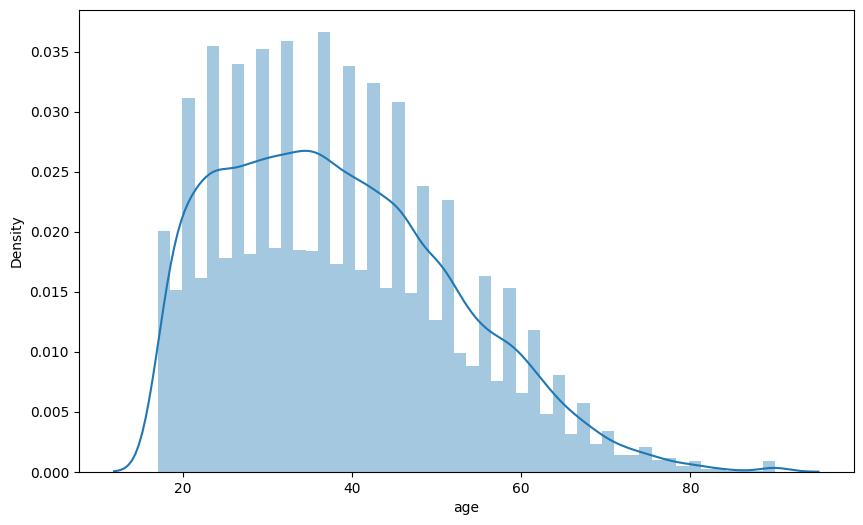

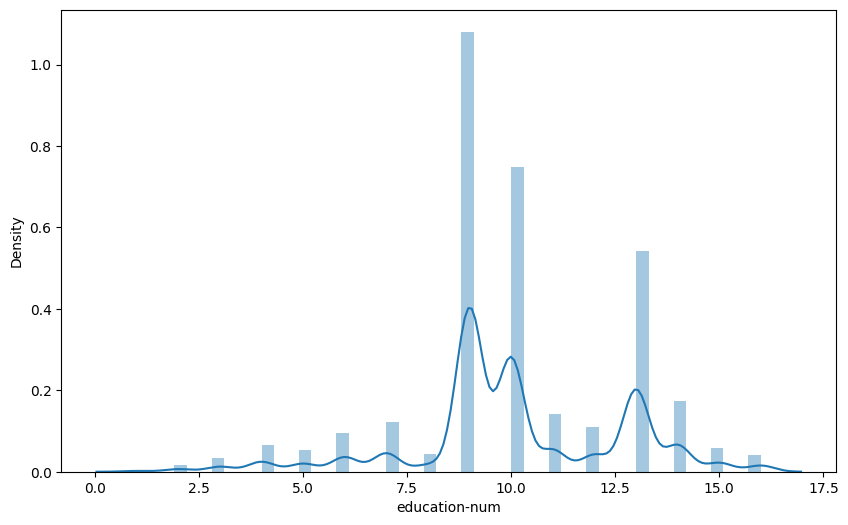

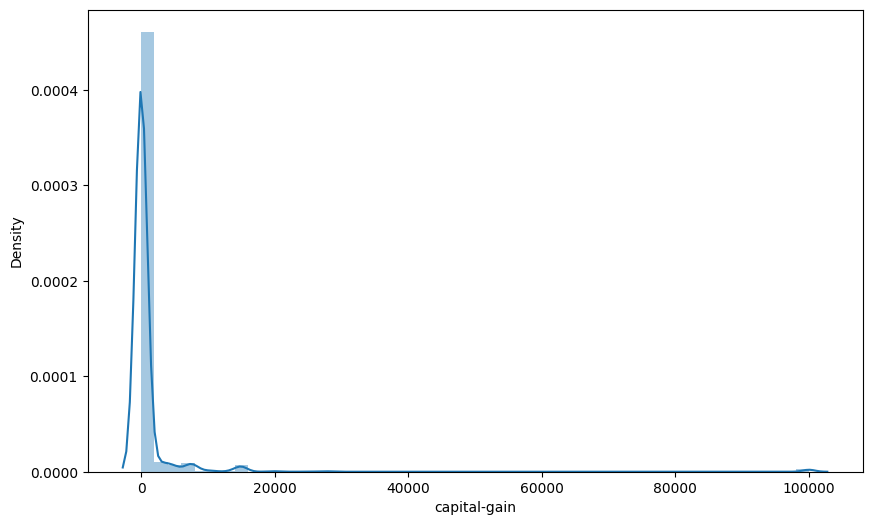

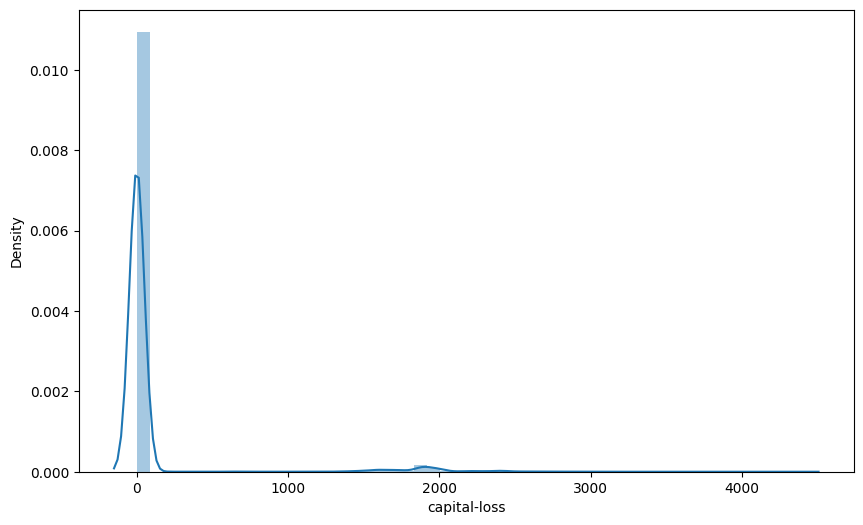

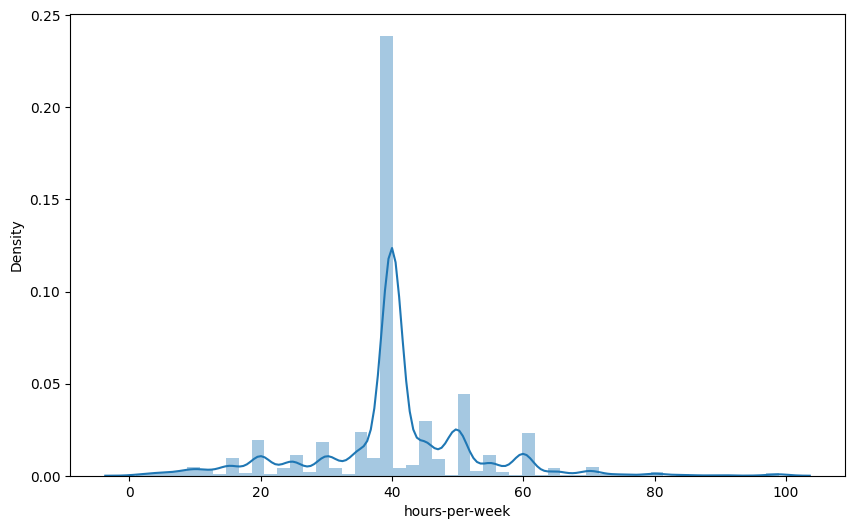

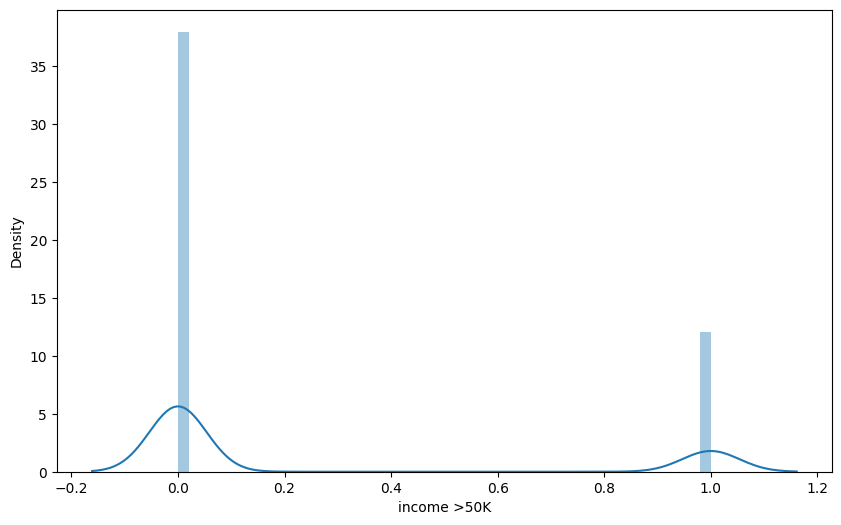

In [17]:
## Start with the continuous features
for col in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.distplot(data[col])

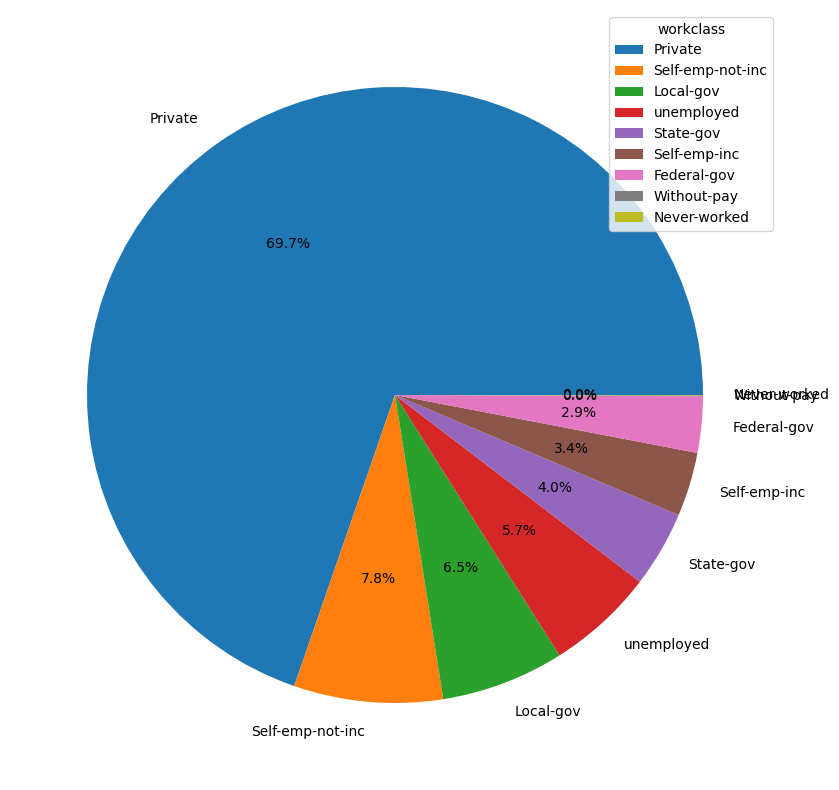

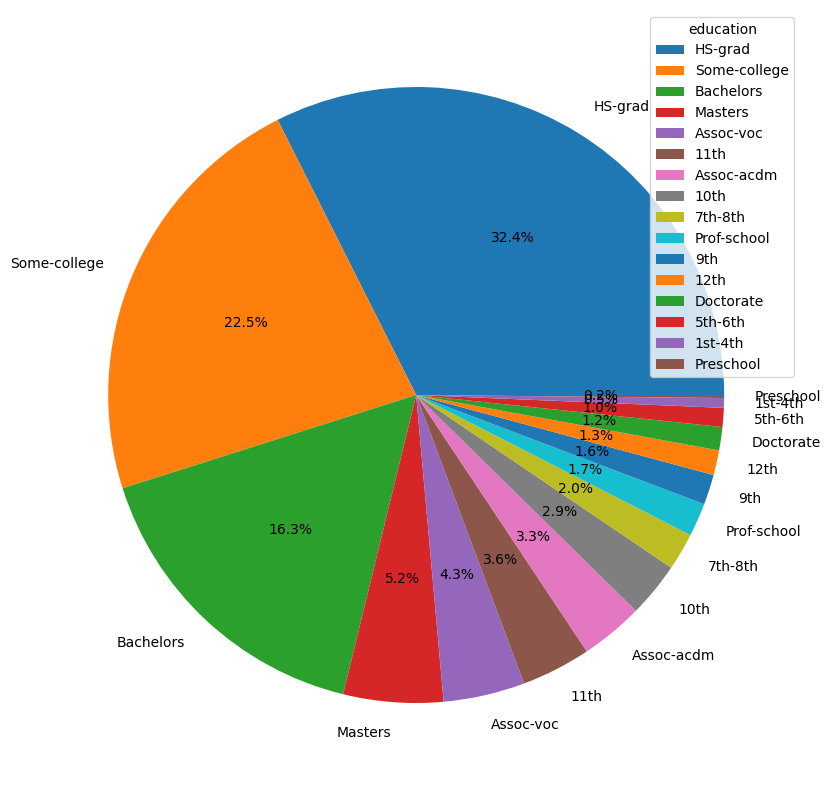

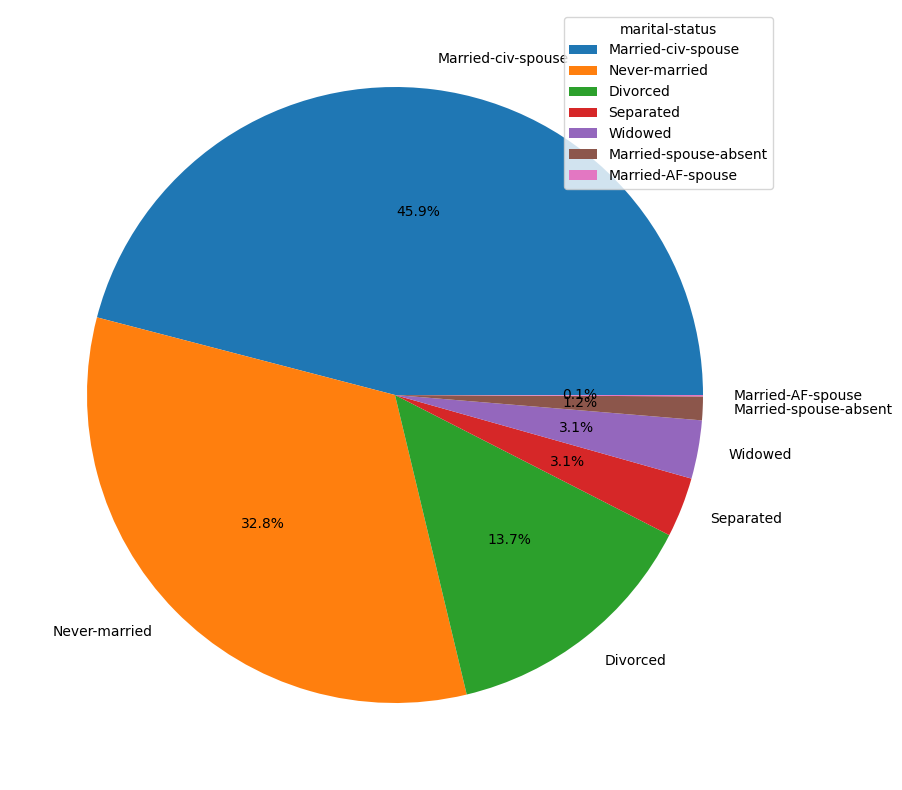

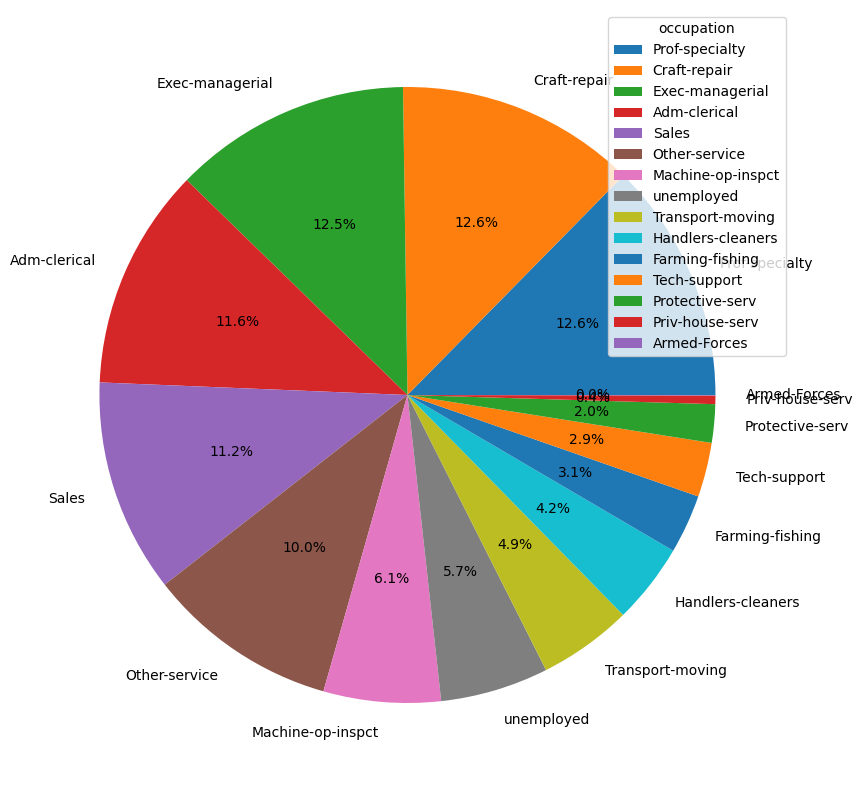

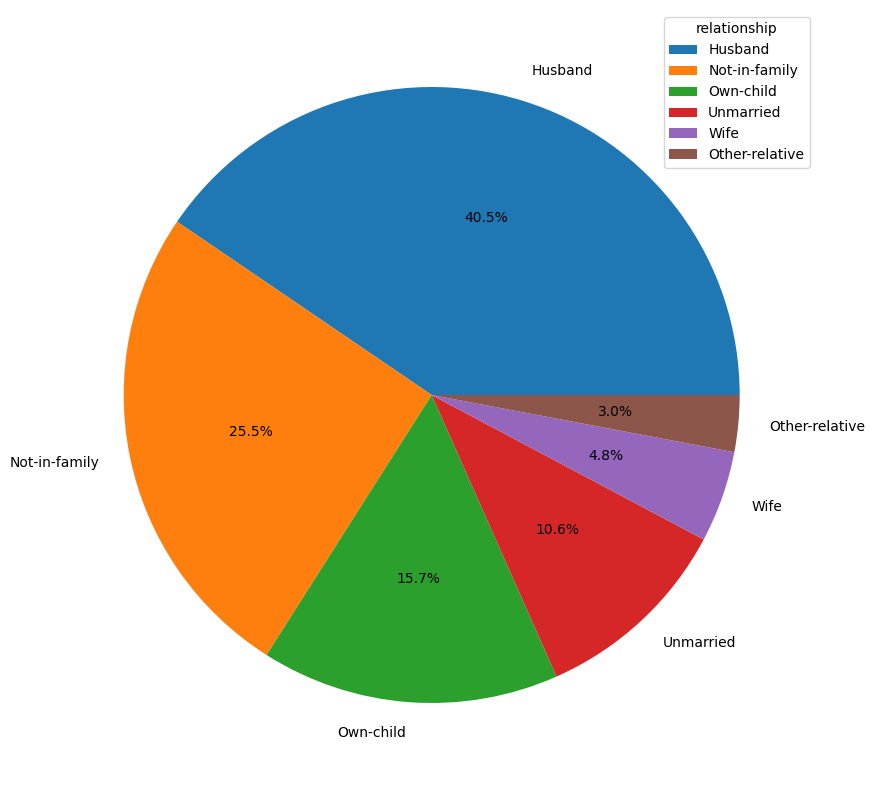

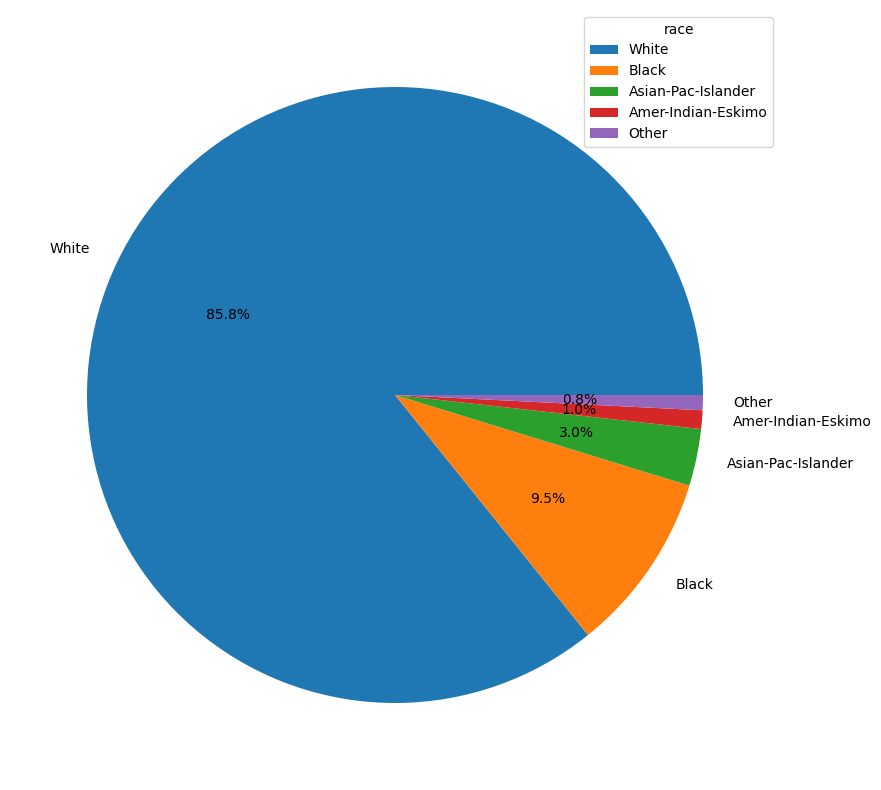

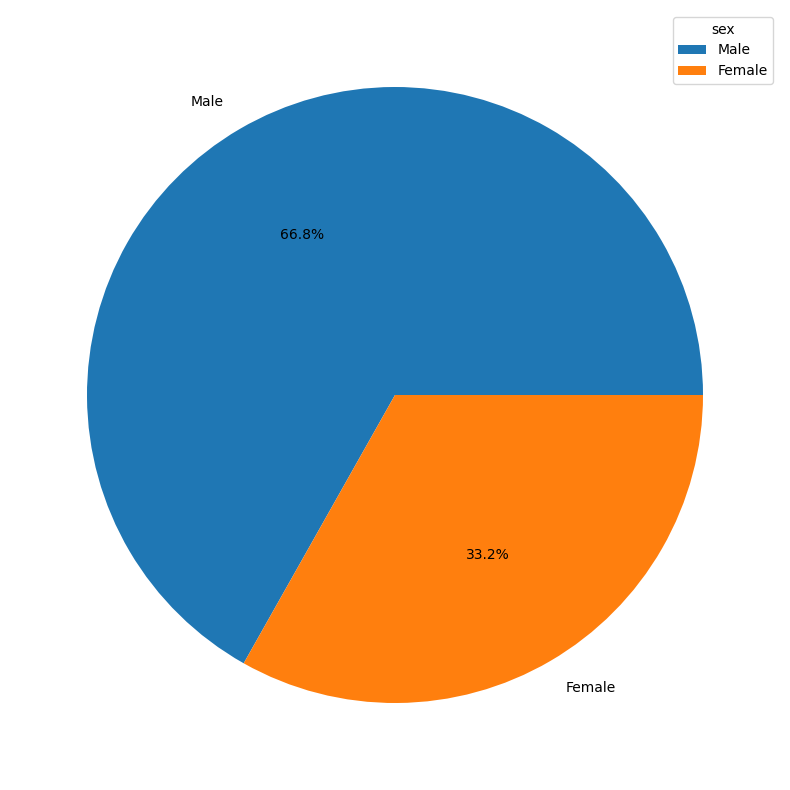

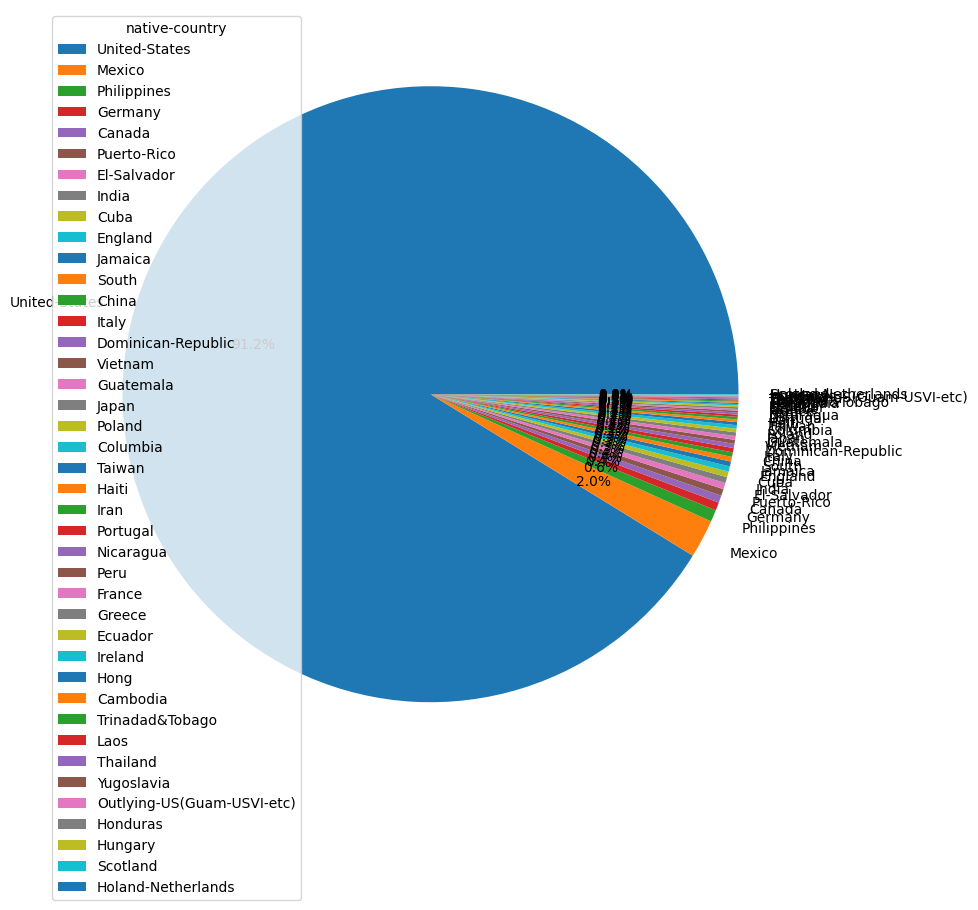

In [18]:
for col in discrete_features:
  plt.figure(figsize=(10,10))
  plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
  plt.legend(title = col)
  plt.show()

These distributions make a good amount of sense and teach us more about where this dataset was taken and the type of people it contains

### To Summarize
This data was most likely taken in the United-States by a largely white male population working mostly in the private sector. The average age is around 30 years old and more make less then 50k a year. 

We notice in our distribution graphs that our target class is heavily weighted, with a much larger density of people with an income less then or equal to 50k a year. This will be important to keep in mind when we are training our models.

There are a total of 13 features: 5 discrete and 7 continuous. Some features are more correlated then others. For example, `education` and `education-num` are the same feature, the latter being just a numerical representation of the former. 

### 3. Brainstorm about the attributes (Feature Engineering)
*Think about the features that could be useful for this task, are they all present in the
dataset? Anything missing? Any attribute provided that doesn’t seem useful to you?*

For the most part we don't believe there to be any missing attributes as the features feel like a comprehensive list of what could be useful for this task. The one feature we think is missing is the location of the individual. This could be useful as some areas are wealthier then others and could therefore be a good indicator of an individual's income. 

The only attribute we believe not worth keeping is `education-num` as it is the same as `education` but encoded as an integer. We will therefore drop this feature.

In [19]:
data.drop('education-num', axis=1, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31978 entries, 0 to 31977
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             31978 non-null  int64 
 1   workclass       31978 non-null  object
 2   education       31978 non-null  object
 3   marital-status  31978 non-null  object
 4   occupation      31978 non-null  object
 5   relationship    31978 non-null  object
 6   race            31978 non-null  object
 7   sex             31978 non-null  object
 8   capital-gain    31978 non-null  int64 
 9   capital-loss    31978 non-null  int64 
 10  hours-per-week  31978 non-null  int64 
 11  native-country  31978 non-null  object
 12  income >50K     31978 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 3.2+ MB


### 4. Encode the Features
*As you will use models that need discrete or continuous attributes, think about data encoding and transformation*

#### 4.1 Processing the data for Naïve Bayes

For the Naive Bayes model, we will use the `Robust Scaler` to scale the continuous features. We are using this scaler as it is less sensitive to outliers then the `Standard Scaler`. We will also use the `One Hot Encoder` to encode the discrete features.


Starting with our discrete features, we will use the robust scaler to normalize our continuous features.

In [21]:
nb_X = data.drop('income >50K', axis=1)
nb_X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,66,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [22]:
## Separate the discrete and continuous features
from sklearn.preprocessing import RobustScaler


discrete_features = [v for v in nb_X.columns if nb_X[v].dtype == 'object']
continuous_features = [v for v in nb_X.columns if nb_X[v].dtype != 'object']

## Scale the continuous features
scaler = RobustScaler()

nb_X[continuous_features] = scaler.fit_transform(nb_X[continuous_features])
nb_X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1.45,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,0.0,United-States
1,0.65,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,-5.4,United-States
2,0.05,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,0.0,United-States
3,0.80,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,0.0,United-States
4,-0.45,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,0.0,Cuba


We will also encode our discrete features using one hot encoding.

In [23]:
enc = OneHotEncoder()

enc_feat = enc.fit_transform(nb_X[discrete_features]).toarray()
enc_feat = pd.DataFrame(enc_feat, columns=np.hstack(enc.categories_))
enc_feat.head()

nb_X = pd.concat([nb_X[continuous_features], enc_feat], axis=1)

Next we will encode our target class to strings to make it easier to read

In [74]:
nb_y = nb_y.map({0: '<=50K', 1: '>50K'})

#### 4.2 Encoding the data for Logistic Regression and Multi-Layer Perceptron
For our Logistic Regression and multi-layer perceptron models, we will use the `MinMaxScaler` to normalize our continuous features. Like with the naive bayes model, we will use the `One Hot Encoder` to encode the discrete features.

In [26]:
lr_X = data.drop('income >50K', axis=1)
lr_X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,66,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [27]:
## Encode the discrete features using one hot encoding
enc = OneHotEncoder()

enc_feat = enc.fit_transform(lr_X[discrete_features]).toarray()
enc_feat = pd.DataFrame(enc_feat, columns=np.hstack(enc.categories_))
enc_feat.head()

lr_X = pd.concat([lr_X[continuous_features], enc_feat], axis=1)
lr_X.head()

,age,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,66,2174,0,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,0,0,13,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,0,0,40,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,0,0,40,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,0,0,40,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
## Normalize the continuous features
from sklearn.preprocessing import MinMaxScaler

lr_X[continuous_features] = MinMaxScaler().fit_transform(lr_X[continuous_features])
lr_X.head()

,age,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,0.671233,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Like our Naive Bayes model, we will encode our target class to strings to make it easier to read.

In [29]:
lr_y = data['income >50K']
lr_y = lr_y.map({0: '<=50K', 1: '>50K'})

## Multi Layer Perceptron has the same data as the logistic regression
mlp_X = lr_X
mlp_y = lr_y

### 5. Prepare your data for the experiment using cross-validation

In [31]:
nb_X_train, nb_X_test, nb_y_train, nb_y_test = train_test_split(nb_X, nb_y, test_size=0.3, random_state=23)
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.3, random_state=23)
mlp_X_train, mlp_X_test, mlp_y_train, mlp_y_test = train_test_split(mlp_X, mlp_y, test_size=0.3, random_state=23)

In [ ]:
from sklearn.model_selection import KFold


nb_folds = KFold(n_splits=10)
lr_folds = 

In [75]:
### 5 Making the folds for our models
kfolds = KFold(n_splits=10)

### 6 Train models on our folds
nb_scores = []
lr_scores = []
mlp_scores = []

In [ ]:
# Train Naive Bayes
for train_index, test_index in kfolds.split(nb_X_train):
  nb_model = GaussianNB()
  nb_model.fit(nb_X_train.iloc[train_index], nb_y_train.iloc[train_index])
  nb_scores.append(nb_model.predict(nb_X_train.iloc[test_index], nb_y_train.iloc[test_index]))

### 6. Training models

#### 6.1 Naïve Bayes

In [32]:
gnb = GaussianNB()

gnb.fit(nb_X_train, nb_y_train)

nb_y_pred = gnb.predict(nb_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(nb_y_test, nb_y_pred)))

Model accuracy score: 0.7912


#### 6.2 Logistic Regression

In [33]:
# Training the model using logistic regression
lr = LogisticRegression(solver='liblinear') # using liblinear instead of default 'lbfgs' solver due to dataset size
lr.fit(lr_X_train, lr_y_train)

lr_y_pred = lr.predict(lr_X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(lr_y_test, lr_y_pred)))

Model accuracy score: 0.8528


#### 6.3 Multi-Layer Perceptron

In [34]:
# Training the model using default parameters
# Default: hidden_layer_sizes=(100,)
mlp = MLPClassifier(max_iter=1000) ## Max iterations set to 1000 to avoid convergence warning
mlp.fit(mlp_X_train, mlp_y_train)

mlp_y_pred = mlp.predict(mlp_X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(mlp_y_test, mlp_y_pred)))

Model accuracy score: 0.8462


### 7. Test your models using cross-validation (provided the splits in step 5)

#### 7.1 Naïve Bayes

In [35]:
from sklearn.model_selection import KFold


# nb_scores = cross_val_score(gnb, nb_X_train, nb_y_train, cv=10, scoring='accuracy')

# print('Cross-validation scores:')
# for i in range(10):
#     print('Fold {}: {:.4f}'.format(i+1, nb_scores[i]))

# print('Average cross-validation score: {:.4f}'.format(nb_scores.mean()))

nb_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in nb_kf.split(nb_X):
    X_train, X_test = nb_X.iloc[train_index], nb_X.iloc[test_index]
    y_train, y_test = nb_y.iloc[train_index], nb_y.iloc[test_index]
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

    

Model accuracy score: 0.7921
Model accuracy score: 0.7892
Model accuracy score: 0.7877
Model accuracy score: 0.7864
Model accuracy score: 0.7849
Model accuracy score: 0.7892
Model accuracy score: 0.7877
Model accuracy score: 0.7939
Model accuracy score: 0.7970
Model accuracy score: 0.7907
Average cross-validation score: 0.7899


#### 7.2 Logistic Regression

In [36]:
# lr_scores = cross_val_score(lr, lr_X_train, lr_y_train, cv=10, scoring='accuracy')

# print('Cross-validation scores:')
# for i in range(10):
#     print('Fold {}: {:.4f}'.format(i+1, lr_scores[i]))

# print('Average cross-validation score: {:.4f}'.format(lr_scores.mean()))

lr_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in lr_kf.split(lr_X):
    X_train, X_test = lr_X.iloc[train_index], lr_X.iloc[test_index]
    y_train, y_test = lr_y.iloc[train_index], lr_y.iloc[test_index]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

Model accuracy score: 0.8430
Model accuracy score: 0.8524
Model accuracy score: 0.8543
Model accuracy score: 0.8393
Model accuracy score: 0.8502
Model accuracy score: 0.8521
Model accuracy score: 0.8540
Model accuracy score: 0.8549
Model accuracy score: 0.8546
Model accuracy score: 0.8461
Average cross-validation score: 0.8501


#### 7.3 Multi-Layer Perceptron

In [37]:
# mlp_scores = cross_val_score(mlp, mlp_X_train, mlp_y_train, cv=10, scoring='accuracy')

# print('Cross-validation scores:')
# for i in range(10):
#     print('Fold {}: {:.4f}'.format(i+1, mlp_scores[i]))

# print('Average cross-validation score: {:.4f}'.format(mlp_scores.mean()))

mlp_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in mlp_kf.split(mlp_X):
    X_train, X_test = mlp_X.iloc[train_index], mlp_X.iloc[test_index]
    y_train, y_test = mlp_y.iloc[train_index], mlp_y.iloc[test_index]
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

Model accuracy score: 0.8346
Model accuracy score: 0.8468
Model accuracy score: 0.8521
Model accuracy score: 0.8336
Model accuracy score: 0.8527
Model accuracy score: 0.8515
Model accuracy score: 0.8390
Model accuracy score: 0.8477
Model accuracy score: 0.8483
Model accuracy score: 0.8417
Average cross-validation score: 0.8448


### 8. Perform an evaluation with precision/recall measures

#### a) Naïve Bayes

##### Confusion Matrix

True Negative: 5654
True Positive: 1937
False Negative: 1599
False Positive: 404


<AxesSubplot: >

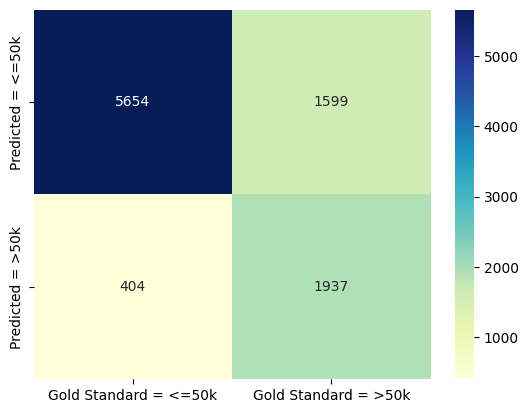

In [38]:
nb_matrix = confusion_matrix(nb_y_test, nb_y_pred)

nb_matrixDf = pd.DataFrame(data=nb_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb_matrix[0,0])
print('True Positive:', nb_matrix[1,1])
print('False Negative:', nb_matrix[0,1])
print('False Positive:', nb_matrix[1,0])

sns.heatmap(nb_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

##### Classification Report

In [39]:
nb_report = classification_report(nb_y_test, nb_y_pred, target_names=['<=50k', '>50k'])
print(nb_report)

              precision    recall  f1-score   support

       <=50k       0.93      0.78      0.85      7253
        >50k       0.55      0.83      0.66      2341

    accuracy                           0.79      9594
   macro avg       0.74      0.80      0.75      9594
weighted avg       0.84      0.79      0.80      9594



##### Summary of results
We notice very quickly that while our model is very precise when it comes to guessing if a person makes less then 50k a year, it is very bad at guessing if a person makes more then 50k a year. We can see this in the precision score of 0.54 for the positive class. This is most likely due to the large class imbalance in our dataset.

#### b) Logistic Regression

True Negative: 6776
True Positive: 1406
False Negative: 477
False Positive: 935


<AxesSubplot: >

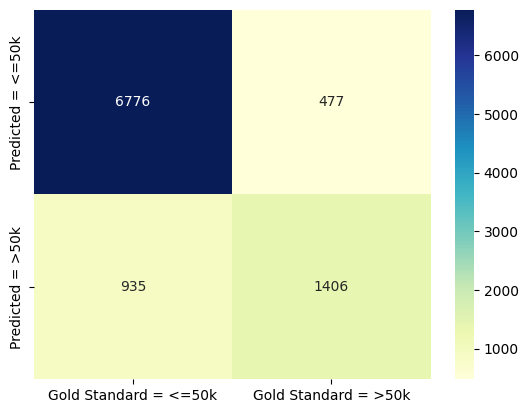

In [40]:
lr_matrix = confusion_matrix(lr_y_test, lr_y_pred)

lr_matrixDf = pd.DataFrame(data=lr_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr_matrix[0,0])
print('True Positive:', lr_matrix[1,1])
print('False Negative:', lr_matrix[0,1])
print('False Positive:', lr_matrix[1,0])

sns.heatmap(lr_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [41]:
lr_report = classification_report(lr_y_test, lr_y_pred, target_names=['<=50k', '>50k'])
print(lr_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.93      0.91      7253
        >50k       0.75      0.60      0.67      2341

    accuracy                           0.85      9594
   macro avg       0.81      0.77      0.79      9594
weighted avg       0.85      0.85      0.85      9594



##### Summary of Results
Unlike our Naive Bayes model, our Logistic Regression model is much more precise when it comes to guessing if a person makes more then 50k a year. However, it's recall score is much lower then our Naive Bayes model. The model overall seems much more hesitant to say an individual makes more then 50k a year when compared to Naive Bayes

#### c) Multi-Layer Perceptron

True Negative: 6639
True Positive: 1479
False Negative: 614
False Positive: 862


<AxesSubplot: >

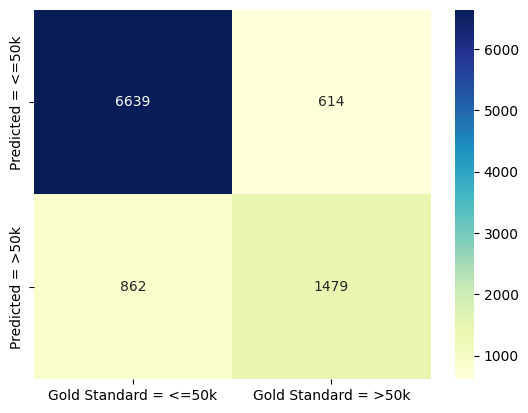

In [42]:
mlp_matrix = confusion_matrix(mlp_y_test, mlp_y_pred)

mlp_matrixDf = pd.DataFrame(data=mlp_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp_matrix[0,0])
print('True Positive:', mlp_matrix[1,1])
print('False Negative:', mlp_matrix[0,1])
print('False Positive:', mlp_matrix[1,0])

sns.heatmap(mlp_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [43]:
mlp_report = classification_report(mlp_y_test, mlp_y_pred, target_names=['<=50k', '>50k'])
print(mlp_report)

              precision    recall  f1-score   support

       <=50k       0.89      0.92      0.90      7253
        >50k       0.71      0.63      0.67      2341

    accuracy                           0.85      9594
   macro avg       0.80      0.77      0.78      9594
weighted avg       0.84      0.85      0.84      9594



##### Summary of results
Again, our MLP model has a better precision score for the positive class then our Naive Bayes model while having a much lower recall score.

### 9. For each type of model, modify some parameters and perform a train/test/evaluate again. Do this twice for each model. 

#### 9.1 Naïve Bayes

##### Run 2
GuassianNB only has two parameters, `var_smoothing` and `priors`. We will only modify `var_smoothing`

Training the model

In [44]:
# Default var smoothing is 1e-9, we will try 1e-11 to see it's effects (if any)
gnb_2 = GaussianNB(var_smoothing=1e-11)

gnb_2.fit(nb_X_train, nb_y_train)

nb_y_pred_2 = gnb_2.predict(nb_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(nb_y_test, nb_y_pred_2)))

Model accuracy score: 0.7206


Test using cross-validation

In [45]:
nb2_scores = cross_val_score(gnb_2, nb_X_train, nb_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, nb2_scores[i]))

print('Average cross-validation score: {:.4f}'.format(nb2_scores.mean()))

Cross-validation scores:
Fold 1: 0.7021
Fold 2: 0.7034
Fold 3: 0.7244
Fold 4: 0.7070
Fold 5: 0.7221
Fold 6: 0.7122
Fold 7: 0.7189
Fold 8: 0.7087
Fold 9: 0.7100
Fold 10: 0.7109
Average cross-validation score: 0.7120


Evaluation

True Negative: 5654
True Positive: 1937
False Negative: 1599
False Positive: 404


<AxesSubplot: >

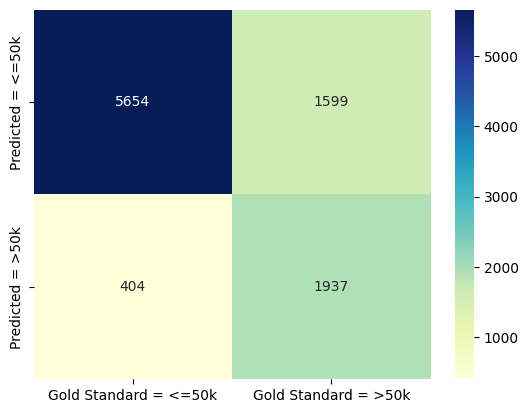

In [46]:
# Confusion Matrix
nb2_matrix = confusion_matrix(nb_y_test, nb_y_pred)

nb2_matrixDf = pd.DataFrame(data=nb2_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb2_matrix[0,0])
print('True Positive:', nb2_matrix[1,1])
print('False Negative:', nb2_matrix[0,1])
print('False Positive:', nb2_matrix[1,0])

sns.heatmap(nb2_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [47]:
# Classification Report
nb2_report = classification_report(nb_y_test, nb_y_pred_2, target_names=['<=50k', '>50k'])
print(nb2_report)

              precision    recall  f1-score   support

       <=50k       0.95      0.67      0.78      7253
        >50k       0.46      0.89      0.61      2341

    accuracy                           0.72      9594
   macro avg       0.71      0.78      0.70      9594
weighted avg       0.83      0.72      0.74      9594



##### Run 3

Training the model

In [48]:
## This time we will try increasing our var_smoothing to 1e-7
gnb_3 = GaussianNB(var_smoothing=1e-7)

gnb_3.fit(nb_X_train, nb_y_train)

nb_y_pred_3 = gnb_3.predict(nb_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(nb_y_test, nb_y_pred_3)))

Model accuracy score: 0.7985


Test using cross-validation

In [49]:
nb3_scores = cross_val_score(gnb_3, nb_X_train, nb_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, nb3_scores[i]))


print('Average cross-validation score: {:.4f}'.format(nb3_scores.mean()))

Cross-validation scores:
Fold 1: 0.7977
Fold 2: 0.7990
Fold 3: 0.7937
Fold 4: 0.7896
Fold 5: 0.7958
Fold 6: 0.7936
Fold 7: 0.7936
Fold 8: 0.7851
Fold 9: 0.7989
Fold 10: 0.7909
Average cross-validation score: 0.7938


Evaluation

True Negative: 6930
True Positive: 731
False Negative: 323
False Positive: 1610


<AxesSubplot: >

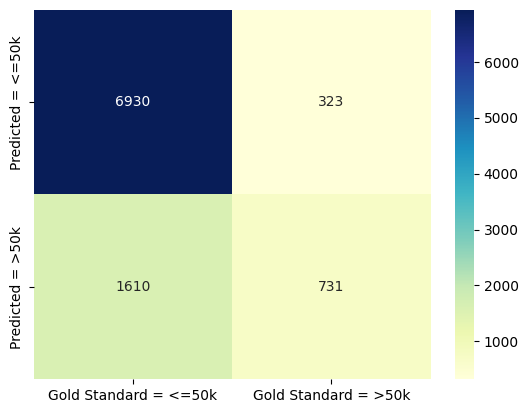

In [50]:
# Confusion Matrix
nb3_matrix = confusion_matrix(nb_y_test, nb_y_pred_3)

nb3_matrixDf = pd.DataFrame(data=nb3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb3_matrix[0,0])
print('True Positive:', nb3_matrix[1,1])
print('False Negative:', nb3_matrix[0,1])
print('False Positive:', nb3_matrix[1,0])

sns.heatmap(nb3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [51]:
# Classification Report
nb3_report = classification_report(nb_y_test, nb_y_pred_3, target_names=['<=50k', '>50k'])
print(nb3_report)

              precision    recall  f1-score   support

       <=50k       0.81      0.96      0.88      7253
        >50k       0.69      0.31      0.43      2341

    accuracy                           0.80      9594
   macro avg       0.75      0.63      0.65      9594
weighted avg       0.78      0.80      0.77      9594



##### Summary of results  

For our second run, we decreased our variable smoothing and noticed that our accuracy went down by a significant amount (from 0.77 to 0.72). We also notice in our classification report that our precision score for the positive class went down by a significant amount (from 0.54 to 0.48). This shows that increasing the variable smoothing decreases the precision of our model.

For our third run, we did the opposite. The accuracy of our model doesn't seem to have been significantly affected (from 0.77 to 0.79). However we see in our classification report that our recall score for the positive class went down by a very large amount (from 0.83 to 0.31). 

#### 9.2 Logistic Regression

##### Run 2
For our second run, we will try to change our penalty from 'l2' to 'l1'.

Training the model

In [52]:
lr_2 = LogisticRegression(solver='liblinear', penalty='l1')
lr_2.fit(lr_X_train, lr_y_train)

lr_y_pred_2 = lr_2.predict(lr_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(lr_y_test, lr_y_pred_2)))

Model accuracy score: 0.8567


Test using cross-validation

In [53]:
lr2_scores = cross_val_score(lr_2, lr_X_train, lr_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, lr2_scores[i]))

print('Average cross-validation score: {:.4f}'.format(lr2_scores.mean()))

Cross-validation scores:
Fold 1: 0.8504
Fold 2: 0.8397
Fold 3: 0.8540
Fold 4: 0.8468
Fold 5: 0.8490
Fold 6: 0.8476
Fold 7: 0.8481
Fold 8: 0.8521
Fold 9: 0.8579
Fold 10: 0.8499
Average cross-validation score: 0.8495


Evaluation

True Negative: 6785
True Positive: 1434
False Negative: 468
False Positive: 907


<AxesSubplot: >

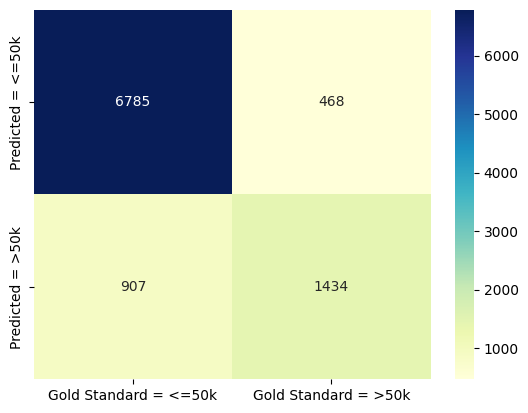

In [54]:
# Confusion Matrix
lr2_matrix = confusion_matrix(lr_y_test, lr_y_pred_2)

lr2_matrixDf = pd.DataFrame(data=lr2_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr2_matrix[0,0])
print('True Positive:', lr2_matrix[1,1])
print('False Negative:', lr2_matrix[0,1])
print('False Positive:', lr2_matrix[1,0])

sns.heatmap(lr2_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [55]:
# Classification Report
lr2_report = classification_report(lr_y_test, lr_y_pred_2, target_names=['<=50k', '>50k'])
print(lr2_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.94      0.91      7253
        >50k       0.75      0.61      0.68      2341

    accuracy                           0.86      9594
   macro avg       0.82      0.77      0.79      9594
weighted avg       0.85      0.86      0.85      9594



##### Run 3

For this run, we will add inverse regularization by setting `C` to 0.2 from 1. Making C smaller increases the regularization strength.

Trainning the model

In [56]:
lr_3 = LogisticRegression(solver='liblinear', C=0.2)
lr_3.fit(lr_X_train, lr_y_train)

lr_y_pred_3 = lr_3.predict(lr_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(lr_y_test, lr_y_pred_3)))

Model accuracy score: 0.8480


Test using cross-validation

In [57]:
lr3_scores = cross_val_score(
    lr_3, lr_X_train, lr_y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:')
for i in range(10):
    print('Fold {}: {:.4f}'.format(i+1, lr3_scores[i]))

print('Average cross-validation score: {:.4f}'.format(lr3_scores.mean()))


Cross-validation scores:
Fold 1: 0.8419
Fold 2: 0.8298
Fold 3: 0.8464
Fold 4: 0.8383
Fold 5: 0.8432
Fold 6: 0.8369
Fold 7: 0.8391
Fold 8: 0.8423
Fold 9: 0.8525
Fold 10: 0.8445
Average cross-validation score: 0.8415


Evaluation

True Negative: 6771
True Positive: 1365
False Negative: 482
False Positive: 976


<AxesSubplot: >

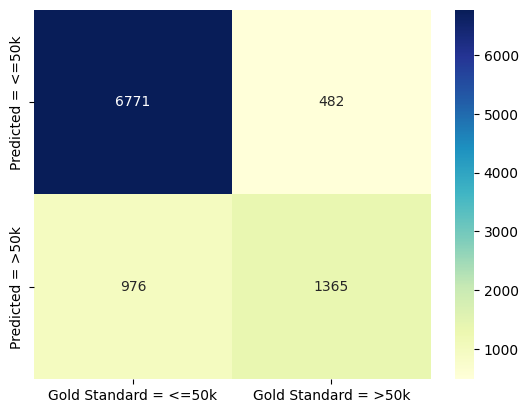

In [58]:
# Confusion Matrix
lr3_matrix = confusion_matrix(lr_y_test, lr_y_pred_3)

lr3_matrixDf = pd.DataFrame(data=lr3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr3_matrix[0,0])
print('True Positive:', lr3_matrix[1,1])
print('False Negative:', lr3_matrix[0,1])
print('False Positive:', lr3_matrix[1,0])

sns.heatmap(lr3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [59]:
# Classification Report
lr3_report = classification_report(lr_y_test, lr_y_pred_3, target_names=['<=50k', '>50k'])
print(lr3_report)

              precision    recall  f1-score   support

       <=50k       0.87      0.93      0.90      7253
        >50k       0.74      0.58      0.65      2341

    accuracy                           0.85      9594
   macro avg       0.81      0.76      0.78      9594
weighted avg       0.84      0.85      0.84      9594



##### Summary of results
Interestingly, our classification reports show that our logistic regression had little to no changes regardless of the settings we changed.

#### 9.3 Multi-Layer Perceptron

##### Run 2

For our second Multi-layer perceptron, we will try to increase the number of hidden layers.

Training the model

In [60]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000) # 2 hidden layers with 100 neurons each, 1000 iterations to avoid convergence warning
mlp_2.fit(mlp_X_train, mlp_y_train)

mlp_y_pred_2 = mlp_2.predict(mlp_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(mlp_y_test, mlp_y_pred_2)))

Model accuracy score: 0.8247


Test using cross-validation

In [61]:
mlp3_scores = cross_val_score(mlp_2, mlp_X_train, mlp_y_train, cv=10)

print('Cross-validation scores:')
for i in range(10):
  print('Fold {}: {:.4f}'.format(i+1, mlp3_scores[i]))

print('Average cross-validation score: {:.4f}'.format(mlp3_scores.mean()))

Cross-validation scores:
Fold 1: 0.8173
Fold 2: 0.8245
Fold 3: 0.8392
Fold 4: 0.8272
Fold 5: 0.8396
Fold 6: 0.8311
Fold 7: 0.8155
Fold 8: 0.8351
Fold 9: 0.8414
Fold 10: 0.8266
Average cross-validation score: 0.8297


Evaluation

True Negative: 6408
True Positive: 1504
False Negative: 845
False Positive: 837


<AxesSubplot: >

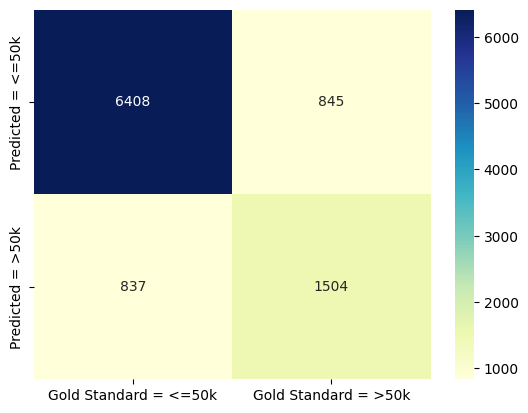

In [62]:
# Confusion Matrix
mlp3_matrix = confusion_matrix(mlp_y_test, mlp_y_pred_2)

mlp3_matrixDf = pd.DataFrame(data=mlp3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp3_matrix[0,0])
print('True Positive:', mlp3_matrix[1,1])
print('False Negative:', mlp3_matrix[0,1])
print('False Positive:', mlp3_matrix[1,0])

sns.heatmap(mlp3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [63]:
# Classification Report
mlp2_report = classification_report(mlp_y_test, mlp_y_pred_2, target_names=['<=50k', '>50k'])
print(mlp2_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.88      0.88      7253
        >50k       0.64      0.64      0.64      2341

    accuracy                           0.82      9594
   macro avg       0.76      0.76      0.76      9594
weighted avg       0.82      0.82      0.82      9594



##### Run 3

For our final run, we will try changing the number of neurons in our hidden layer.

Training the model

In [64]:
mlp_3 = MLPClassifier(hidden_layer_sizes=(200), max_iter=1000) # 1 hidden layer with 200 neurons, 1000 iterations to avoid convergence warning
mlp_3.fit(mlp_X_train, mlp_y_train)

mlp_y_pred_3 = mlp_3.predict(mlp_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(mlp_y_test, mlp_y_pred_3)))

Model accuracy score: 0.8363


Test using cross-validation

In [65]:
mlp3_scores = cross_val_score(mlp_3, mlp_X_train, mlp_y_train, cv=10)

print('Cross-validation scores:')
for i in range(10):
  print('Fold {}: {:.4f}'.format(i+1, mlp3_scores[i]))

print('Average cross-validation score: {:.4f}'.format(mlp3_scores.mean()))

Cross-validation scores:
Fold 1: 0.8370
Fold 2: 0.8196
Fold 3: 0.8437
Fold 4: 0.8356
Fold 5: 0.8409
Fold 6: 0.8360
Fold 7: 0.8365
Fold 8: 0.8333
Fold 9: 0.8374
Fold 10: 0.8378
Average cross-validation score: 0.8358


Evaluation

True Negative: 6434
True Positive: 1589
False Negative: 819
False Positive: 752


<AxesSubplot: >

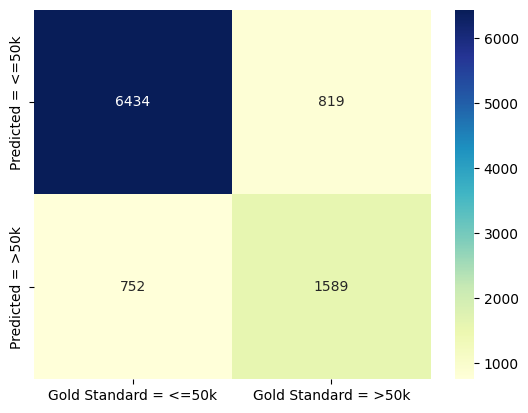

In [66]:
# Confusion Matrix
mlp3_matrix = confusion_matrix(mlp_y_test, mlp_y_pred_3)

mlp3_matrixDf = pd.DataFrame(data=mlp3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp3_matrix[0,0])
print('True Positive:', mlp3_matrix[1,1])
print('False Negative:', mlp3_matrix[0,1])
print('False Positive:', mlp3_matrix[1,0])

sns.heatmap(mlp3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [67]:
# Classification Report
mlp3_report = classification_report(mlp_y_test, mlp_y_pred_3, target_names=['<=50k', '>50k'])
print(mlp3_report)

              precision    recall  f1-score   support

       <=50k       0.90      0.89      0.89      7253
        >50k       0.66      0.68      0.67      2341

    accuracy                           0.84      9594
   macro avg       0.78      0.78      0.78      9594
weighted avg       0.84      0.84      0.84      9594



#### Summary of results

### 10. Analyze the obtained results

##### a) *Compare quantitatively (with the precision/recall measures) your 9 results. The 9 results come from 3 models, each with default parameters from step 6 + 2 variations from step 9.*

Naive Bayes

In [68]:
# Print our NB classification reports
print('Run 1')
print(nb_report)

print('Run 2')
print(nb2_report)

print('Run 3')
print(nb3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.93      0.78      0.85      7253
        >50k       0.55      0.83      0.66      2341

    accuracy                           0.79      9594
   macro avg       0.74      0.80      0.75      9594
weighted avg       0.84      0.79      0.80      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.95      0.67      0.78      7253
        >50k       0.46      0.89      0.61      2341

    accuracy                           0.72      9594
   macro avg       0.71      0.78      0.70      9594
weighted avg       0.83      0.72      0.74      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.81      0.96      0.88      7253
        >50k       0.69      0.31      0.43      2341

    accuracy                           0.80      9594
   macro avg       0.75      0.63      0.65      9594
weighted avg       0.78      0.80      0.77      9594



In [69]:
print('Average NB Precision Macro Avg: {:.2f}'.format((0.74+0.71+0.78)/3 * 100))
print('Average NB Recall Macro Avg: {:.2f}'.format((0.80+0.63+0.78)/3 * 100))
print('\n')
print('Average NB Precision Weighted Avg: {:.2f}'.format((0.84+0.83+0.78)/3 * 100))
print('Average NB Recall Weighted Avg: {:.2f}'.format((0.79+0.73+0.80)/3 * 100))

Average NB Precision Macro Avg: 74.33
Average NB Recall Macro Avg: 73.67


Average NB Precision Weighted Avg: 81.67
Average NB Recall Weighted Avg: 77.33


Logistic Regression

In [70]:
# Print our LR classification reports
print('Run 1')
print(lr_report)

print('Run 2')
print(lr2_report)

print('Run 3')
print(lr3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.88      0.93      0.91      7253
        >50k       0.75      0.60      0.67      2341

    accuracy                           0.85      9594
   macro avg       0.81      0.77      0.79      9594
weighted avg       0.85      0.85      0.85      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.88      0.94      0.91      7253
        >50k       0.75      0.61      0.68      2341

    accuracy                           0.86      9594
   macro avg       0.82      0.77      0.79      9594
weighted avg       0.85      0.86      0.85      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.87      0.93      0.90      7253
        >50k       0.74      0.58      0.65      2341

    accuracy                           0.85      9594
   macro avg       0.81      0.76      0.78      9594
weighted avg       0.84      0.85      0.84      9594



In [71]:
print('Average LR Precision Macro Avg: {:.2f}'.format((0.78+0.79+0.78)/3 * 100))
print('Average LR Recall Macro Avg: {:.2f}'.format((0.75+0.75+0.74)/3 * 100))
print('\n')
print('Average LR Precision Weighted Avg: {:.2f}'.format((0.83+0.83+0.83)/3 * 100))
print('Average LR Recall Weighted Avg: {:.2f}'.format((0.84+0.84+0.84)/3 * 100))

Average LR Precision Macro Avg: 78.33
Average LR Recall Macro Avg: 74.67


Average LR Precision Weighted Avg: 83.00
Average LR Recall Weighted Avg: 84.00


Multi-Layer Perceptron

In [72]:
# Print our MLP classification reports
print('Run 1')
print(mlp_report)

print('Run 2')
print(mlp2_report)

print('Run 3')
print(mlp3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.89      0.92      0.90      7253
        >50k       0.71      0.63      0.67      2341

    accuracy                           0.85      9594
   macro avg       0.80      0.77      0.78      9594
weighted avg       0.84      0.85      0.84      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.88      0.88      0.88      7253
        >50k       0.64      0.64      0.64      2341

    accuracy                           0.82      9594
   macro avg       0.76      0.76      0.76      9594
weighted avg       0.82      0.82      0.82      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.90      0.89      0.89      7253
        >50k       0.66      0.68      0.67      2341

    accuracy                           0.84      9594
   macro avg       0.78      0.78      0.78      9594
weighted avg       0.84      0.84      0.84      9594



In [73]:
print('Average MLP Precision Macro Avg: {:.2f}'.format((0.79+0.77+0.78)/3 * 100))
print('Average MLP Recall Macro Avg: {:.2f}'.format((0.75+0.75+0.75)/3 * 100))
print('\n')
print('Average MLP Precision Weighted Avg: {:.2f}'.format((0.83+0.83+0.83)/3 * 100))
print('Average MLP Weighted Avg: {:.2f}'.format((0.84+0.83+0.83)/3 * 100))

Average MLP Precision Macro Avg: 78.00
Average MLP Recall Macro Avg: 75.00


Average MLP Precision Weighted Avg: 83.00
Average MLP Weighted Avg: 83.33


- Naive Bayes is the only model to see significant changes in performance when changing the parameters. Logistic regression and multi-layer perceptron saw minimal changes to all it's scores (variations of 1 or 2%).
- All models had a large difference in score between the positive and negative classes. This is most likely due to the imbalance in our dataset.
- On average, Logistic Regression had the highest accuracy across of all our models. It also had the least variance between runs, with minimal changes to our classification report regardless of the parameters we changed.
- Of the three models Logistic Regression had the best precision for the positive class, but Naive Bayes had the best precision for the negative class
- Of the three models, the second run of Naive Bayes achieved the highest recall for the positive class, but Logistic Regression had the highest recall for the negative class

##### b) *Compare quantitatively (with the precision/recall measures) your 9 results. The 9 results come from 3 models, each with default parameters from step 6 + 2 variations from step 9.*